# Advanced Data Science for MPS

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from load_data_common import load_data
import seaborn as sns
import math

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedKFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

%matplotlib inline
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 16
plt.rcParams['savefig.facecolor'] = 'white'

## Import MPS data

In [23]:
df_features, df_traces = load_data()
print(f"Number of samples: {df_features.shape[0]}")

Number of samples: 484


Let's look at the columns in our data

In [24]:
print(df_features.columns)

Index(['drug', 'experiment', 'well', 'tissue', 'dose', 'dose_float',
       'voltage_apd30', 'voltage_apd50', 'voltage_apd80', 'voltage_apd90',
       'voltage_beating_frequencies', 'voltage_beating_frequency',
       'voltage_capd30', 'voltage_capd50', 'voltage_capd80', 'voltage_capd90',
       'voltage_dFdt_max', 'voltage_int30', 'voltage_num_beats',
       'voltage_num_eads', 'voltage_slope_APD80', 'voltage_slope_cAPD80',
       'voltage_tau75', 'voltage_triangulation', 'voltage_ttp',
       'voltage_upstroke80', 'calcium_apd30', 'calcium_apd50', 'calcium_apd80',
       'calcium_apd90', 'calcium_beating_frequencies',
       'calcium_beating_frequency', 'calcium_capd30', 'calcium_capd50',
       'calcium_capd80', 'calcium_capd90', 'calcium_dFdt_max', 'calcium_int30',
       'calcium_num_beats', 'calcium_num_eads', 'calcium_slope_APD80',
       'calcium_slope_cAPD80', 'calcium_tau75', 'calcium_triangulation',
       'calcium_ttp', 'calcium_upstroke80',
       'brightfield_Max contract

## Format data for analysis

We need to change features into a form that represents the relative change for a given dose

$$f^{*}_d = \frac{f_d}{f_{d=0}}$$

We will limit our choice of features to a subset.


In [25]:
features_of_interest = ['voltage_apd30', 'voltage_apd50', 'voltage_apd80', 'voltage_apd90',
                       'calcium_apd30', 'calcium_apd50', 'calcium_apd80', 'calcium_apd90',
                       'brightfield_Max contraction velocity [μm/s]', 'brightfield_Max relaxation velocity [μm/s]',
                       'brightfield_Time between contraction and relaxation [ms]',
                       'brightfield_Width at half height (displacement)[ms]']

# find unique rows based on columns
filter_names = ["drug", "well", "tissue"]
dff = df_features[filter_names].drop_duplicates()

df_norm = df_features.copy()

idxs_drop = []
for row in dff.itertuples():
    idxs = np.where((df_norm["drug"] == row.drug) & (df_norm["well"] == row.well) & (df_norm["tissue"] == row.tissue))[0]
    try:
        idx_bl = np.where((df_norm["drug"]==row.drug) & (df_norm["well"]==row.well) & (df_norm["tissue"]==row.tissue) & (df_norm["dose"]=="baseline"))
        a = df_norm[features_of_interest].iloc[idxs].values   # dosed values
        b = df_norm[features_of_interest].iloc[idx_bl].values # baseline values
        df_norm.loc[idxs, features_of_interest] = np.divide(a, b)
    except:
        for i in idxs: idxs_drop.append(i)
        continue
df_norm.drop(idxs_drop, inplace=True)
df_norm.reset_index(drop=True, inplace=True)


## Import drug summary table

Each drug will be treated as a class, with a corresponding mechanism of action that we will code as integer labels 0, 1, 2, ...

In [26]:
drug_mechanism = {
    "omecamtiv":"TnC agonist",
    "Nifedipine":"L-type Ca block",
    "Verapamil":"L-type Ca block, hERG block",
    "Bay_K":"L-type Ca block",
    "Dofetilide":"hERG block",
    "Flecainide":"Fast Na block, hERG block, RyR block",
    "Digoxin":"Na-K ATPase",
    "dobutamine":"beta adrenergic blocker",
    "carvedilol":"beta adrenergic blocker",
    "blebbistatin":"myosin ATPase blocker",
    "levosimendan":"potassium modulation, TnC agonist",
    "milrinone":"beta adrenergic agonist",
    "Isoproterenol":"beta adrenergic agonist",
    "Alfuzosin":"alpha adrenergic block",
    "Bepridil":"multi channel block",
    "Cisapride":"hERG block",
    "Terfenadine":"H1 receptor agonist",
    "Control":"NA", 
    "aspirin":"NA"
}

mechanism_list = list(set(drug_mechanism.values()))
mechanism_class = {
    mech:idx for mech,idx in zip(mechanism_list, range(len(mechanism_list)))
}
print(f"Number of unique drug classes = {len(mechanism_class)}")

Number of unique drug classes = 14


Let's check that the drugs in our data are listed in drug_mechanism

In [27]:
data_drugs = list(set(df_features.drug))
check = np.any([d not in drug_mechanism for d in data_drugs])
if check:
    print("Oops! Some drugs from data are not in the drug mechanism list!")
else:
    print("Looks good! All drugs are in list.")

Looks good! All drugs are in list.


## Unsupervised clustering

The first analysis we will perform is to see how the data naturally clusters using a simple k-means clustering algorithm.  
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

This algorithm "seeds" (i.e., places) a specified number of cluster centers and iteratively moves them based on a distance minimization process (minimizing a criterion known as the within-cluster sum-of-squares)

$$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$$

### Run k-means clustering

In [28]:
# my_features = ["dose_float", "voltage_apd30", "voltage_apd60", "voltage_apd80", "voltage_apd90"]
my_features = features_of_interest

df_X = df_norm[(df_norm["dose"]!="baseline")].dropna(inplace=False)
X = df_X.loc[:, my_features]
print(f"Number of data points = {len(X)}")

n_clusters = 14 # set to equal the number of drugs/mechanisms
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(X)
X_tf = kmeans.transform(X)

Number of data points = 267


Now we compare the real drug name and class of mechanism to the assigned cluster labels

In [29]:
drug_as_mechanism_class = [mechanism_class[drug_mechanism[d]] for d in df_X["drug"].values]
compare = [[d, mc, cc] for d,mc,cc in zip(df_X["drug"].values, drug_as_mechanism_class, kmeans.labels_)]

cluster_centers = kmeans.cluster_centers_
cluster_dist = {f"dist_c{i}":X_tf[:,i] for i in range(n_clusters)}

data = {"drug":df_X["drug"], 
        "mechanism":[drug_mechanism[d] for d in df_X["drug"].values],
        "mechanism_class":drug_as_mechanism_class,
        "kmeans_label":kmeans.labels_
       }
data = {**data, **cluster_dist}

df_kmeans = pd.DataFrame(data=data)

In [30]:
# Calculate distance between each cluster center
cluster_dist_2d = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        cluster_dist_2d[i,j] = math.dist(cluster_centers[i], cluster_centers[j])

Plot the frequency of each cluster for each drug

<Axes: xlabel='kmeans_label', ylabel='drug'>

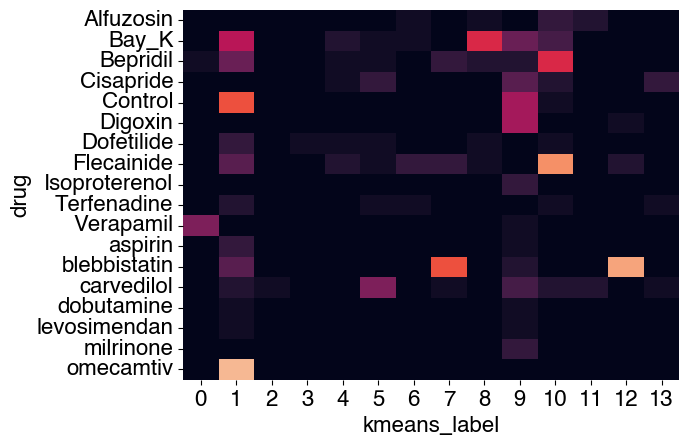

In [31]:
df_count = pd.crosstab(df_kmeans["drug"], df_kmeans["kmeans_label"])
sns.heatmap(data=df_count,
           vmin=0,
           vmax=22,
           xticklabels=True,
           yticklabels=True,
           cbar=False)

Plot the distance between each cluster center

Text(0.5, 1.0, 'Distance between kmeans clusters')

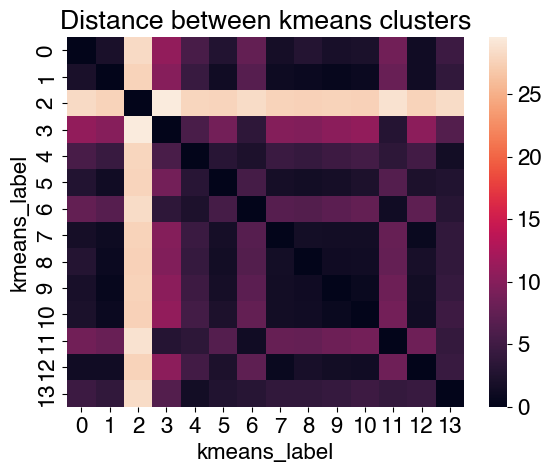

In [32]:
cluster_dist_2d = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        cluster_dist_2d[i,j] = math.dist(cluster_centers[i], cluster_centers[j])
        
g = sns.heatmap(cluster_dist_2d)
g.set_xlabel("kmeans_label")
g.set_ylabel("kmeans_label")
g.set_title("Distance between kmeans clusters")

## Supervised learning

Unsupervised clustering is a useful way to identify groups in data in an unbiased way, the goal of which is to see if data is naturally separable in a meaningful way.

Supervised learning has a different goal: We seek to classify new data based on what we know about existing data.

The steps for supervised classification are:
1. Partition data <br>
    a. Training and testing sets (typically 80/20 split) <br>
    b. Validation set (important but exluded here) 
2. Initialize your classifier 
3. Train the classifier 
4. Test the classifier using the testing set and evaluate the accuracy

### Partition data

Notice the option to include "stratify=drug" in `train_test_split()`. This ensures we are taking samples from each class for our test set.

In [79]:
my_features = features_of_interest

df_X = df_norm[(df_norm["dose"]!="baseline")].dropna(inplace=False)

X_train, X_test = train_test_split(df_X, test_size=0.2, stratify=df_X['drug'], random_state=0)

### Initialize classifier (SVC)

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [80]:
knn = KNeighborsClassifier(n_neighbors=3)

### Train the classifier

In [81]:
knn.fit(X_train.loc[:, my_features], X_train.loc[:, "drug"])

KNeighborsClassifier(n_neighbors=3)

### Test the classifier

Classifier score = 0.56
              precision    recall  f1-score   support

   Alfuzosin       1.00      1.00      1.00         1
       Bay_K       0.42      0.71      0.53         7
    Bepridil       0.50      0.33      0.40         6
   Cisapride       0.33      0.33      0.33         3
     Control       0.50      0.60      0.55         5
     Digoxin       0.50      0.50      0.50         2
  Dofetilide       0.00      0.00      0.00         2
  Flecainide       0.71      0.71      0.71         7
 Terfenadine       0.00      0.00      0.00         1
   Verapamil       1.00      1.00      1.00         2
     aspirin       0.00      0.00      0.00         1
blebbistatin       0.88      0.88      0.88         8
  carvedilol       0.33      0.25      0.29         4
   milrinone       0.00      0.00      0.00         1
   omecamtiv       0.67      0.50      0.57         4

    accuracy                           0.56        54
   macro avg       0.46      0.45      0.45        54
we

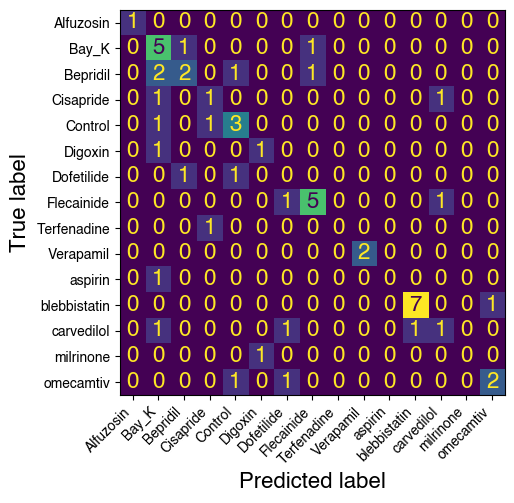

In [82]:
prediction = knn.predict(X_test.loc[:, my_features])
score = knn.score(X_test.loc[:, my_features], X_test.loc[:, "drug"])

print(f"Classifier score = {score:0.2f}")

print(classification_report(X_test.loc[:, "drug"].values, prediction, zero_division=0))

fig, ax = plt.subplots(figsize=(10, 5))
g = ConfusionMatrixDisplay.from_predictions(X_test.loc[:, "drug"].values, prediction, ax=ax, colorbar=None)
plt.yticks(fontsize=10);
plt.xticks(rotation=45, ha="right", fontsize=10);

## Exercise: Play around with the parameters of the classifier

In the example above, we chose a few options which may affect the accuracy of the classifier:
- ratio in `train_test_split()`
- n_neighbors in `KNeighborsClassifier` 

Let's explore what happens when you change these parameters

Classifier score = 0.56
              precision    recall  f1-score   support

   Alfuzosin       1.00      1.00      1.00         1
       Bay_K       0.42      0.71      0.53         7
    Bepridil       0.50      0.33      0.40         6
   Cisapride       0.33      0.33      0.33         3
     Control       0.50      0.60      0.55         5
     Digoxin       0.50      0.50      0.50         2
  Dofetilide       0.00      0.00      0.00         2
  Flecainide       0.71      0.71      0.71         7
 Terfenadine       0.00      0.00      0.00         1
   Verapamil       1.00      1.00      1.00         2
     aspirin       0.00      0.00      0.00         1
blebbistatin       0.88      0.88      0.88         8
  carvedilol       0.33      0.25      0.29         4
   milrinone       0.00      0.00      0.00         1
   omecamtiv       0.67      0.50      0.57         4

    accuracy                           0.56        54
   macro avg       0.46      0.45      0.45        54
we

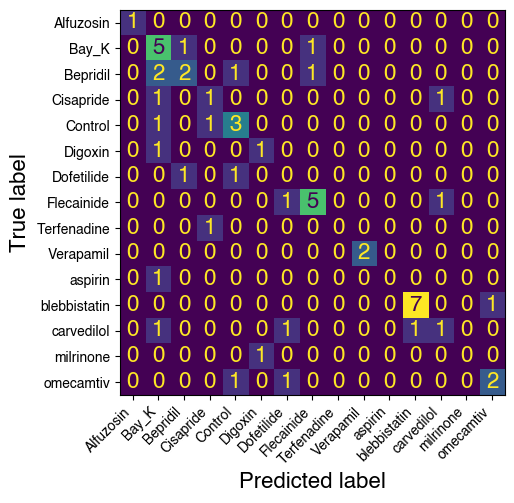

In [91]:
test_size = 0.2
n_neighbors = 3
random_state = 0

X_train, X_test = train_test_split(df_X, test_size=test_size, stratify=df_X['drug'], random_state=random_state)
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train.loc[:, my_features], X_train.loc[:, "drug"])

prediction = knn.predict(X_test.loc[:, my_features])
score = knn.score(X_test.loc[:, my_features], X_test.loc[:, "drug"])
print(f"Classifier score = {score:0.2f}")
print(classification_report(X_test.loc[:, "drug"].values, prediction, zero_division=0))
fig, ax = plt.subplots(figsize=(10, 5))
g = ConfusionMatrixDisplay.from_predictions(X_test.loc[:, "drug"].values, prediction, ax=ax, colorbar=None)
plt.yticks(fontsize=10);
plt.xticks(rotation=45, ha="right", fontsize=10);

## Feature selection

So far we have been using 12 selected features from our feature list.  
Let's explore how our supervised learning classifier performs when we play around with our feature list, with the goal of finding an optimal set of features that improves our classification accuracy.

### Exercise: Manually choose features for the classifier

Classifier score = 0.56


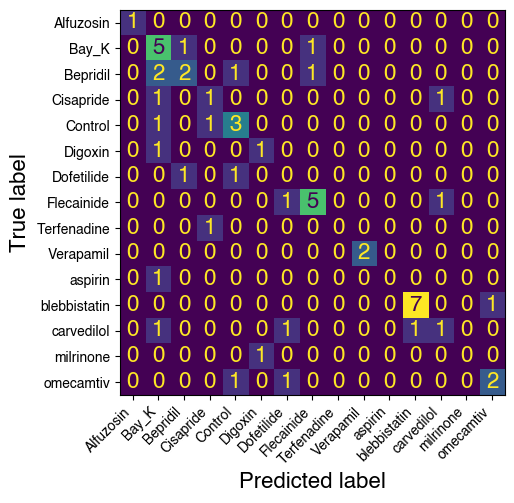

In [98]:
my_features = ['voltage_apd30', 'voltage_apd50', 'voltage_apd80', 'voltage_apd90',
               'calcium_apd30', 'calcium_apd50', 'calcium_apd80', 'calcium_apd90',
               'brightfield_Max contraction velocity [μm/s]',
               'brightfield_Max relaxation velocity [μm/s]',
               'brightfield_Time between contraction and relaxation [ms]',
               'brightfield_Width at half height (displacement)[ms]'
              ]

# Use the same parameters from your best result above
test_size = 0.2
n_neighbors = 3
random_state = 0

X_train, X_test = train_test_split(df_X, test_size=test_size, stratify=df_X['drug'], random_state=random_state)
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train.loc[:, my_features], X_train.loc[:, "drug"])

prediction = knn.predict(X_test.loc[:, my_features])
score = knn.score(X_test.loc[:, my_features], X_test.loc[:, "drug"])
print(f"Classifier score = {score:0.2f}")
# print(classification_report(X_test.loc[:, "drug"].values, prediction, zero_division=0))
fig, ax = plt.subplots(figsize=(10, 5))
g = ConfusionMatrixDisplay.from_predictions(X_test.loc[:, "drug"].values, prediction, ax=ax, colorbar=None)
plt.yticks(fontsize=10);
plt.xticks(rotation=45, ha="right", fontsize=10);

### Automated selection of best features

Best features: ['calcium_apd30', 'calcium_apd50', 'calcium_apd80', 'brightfield_Max relaxation velocity [μm/s]', 'brightfield_Width at half height (displacement)[ms]']
Classifier score for RandomForest = 1.00
Classifier score for kNN = 0.49


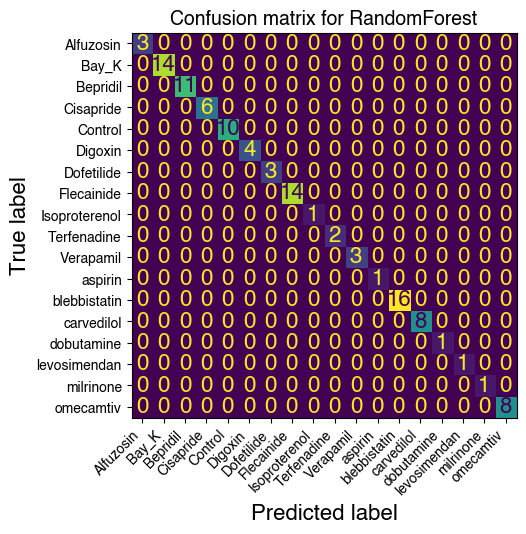

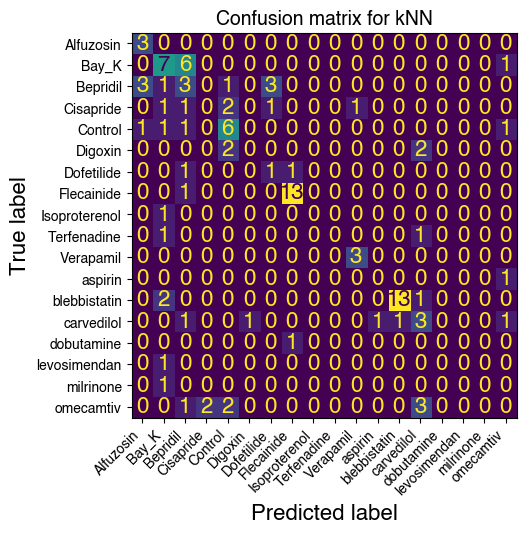

In [128]:
my_features = ['voltage_apd30', 'voltage_apd50', 'voltage_apd80', 'voltage_apd90',
               'calcium_apd30', 'calcium_apd50', 'calcium_apd80', 'calcium_apd90',
               'brightfield_Max contraction velocity [μm/s]',
               'brightfield_Max relaxation velocity [μm/s]',
               'brightfield_Time between contraction and relaxation [ms]',
               'brightfield_Width at half height (displacement)[ms]'
              ]

test_size = 0.2
random_state = 0

X_train, X_test = train_test_split(df_X, test_size=test_size, stratify=df_X['drug'], random_state=random_state)
selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=5, step=1, verbose=0)
selector = selector.fit(X_test.loc[:, my_features], X_test.loc[:,"drug"])
selected_features = list(np.array(my_features)[selector.support_])
print("Best features:", selected_features)
# selector.ranking_

prediction = selector.predict(X_test.loc[:, my_features])
score = selector.score(X_test.loc[:, my_features], X_test.loc[:, "drug"])
print(f"Classifier score for RandomForest = {score:0.2f}")
fig, ax = plt.subplots(figsize=(10, 5))
g = ConfusionMatrixDisplay.from_predictions(X_test.loc[:, "drug"].values, prediction, ax=ax, colorbar=None)
plt.yticks(fontsize=10);
plt.xticks(rotation=45, ha="right", fontsize=10);
plt.title("Confusion matrix for RandomForest", fontsize=14);


knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train.loc[:, selected_features], X_train.loc[:, "drug"])
prediction = knn.predict(X_test.loc[:, selected_features])
score = knn.score(X_test.loc[:, selected_features], X_test.loc[:, "drug"])
print(f"Classifier score for kNN = {score:0.2f}")
fig, ax = plt.subplots(figsize=(10, 5))
g = ConfusionMatrixDisplay.from_predictions(X_test.loc[:, "drug"].values, prediction, ax=ax, colorbar=None)
plt.yticks(fontsize=10);
plt.xticks(rotation=45, ha="right", fontsize=10);
plt.title("Confusion matrix for kNN", fontsize=14);

## Dimensionality reduction

Dimensionality reduction is a techique for reducing the number of input features for a supervised learning task

One method for dimensionality reduction is Principal Component Analysis (PCA) which creates a set of orthogonal components that maximize the variation along each dimension, from highest variance in the first component to a lower variance in each successive component.

Let's try using PCA to create a new set of features, M, where M is less than the original number of features in our list.

In [ ]:
# Dim reduction here

# Exercise where different features are chosen for classification and 